### Hanan Alsalamah



### 1. Problem Statement:

Real estate agents get asked nearly every day about land prices. Predicting the expected average prices for the next years would help people to know the future market trends for their decision making.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import (LinearRegression, 
                                  TheilSenRegressor, 
                                  RANSACRegressor, 
                                  HuberRegressor,
                                  Ridge,
                                  Lasso)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [2]:
# Read the data
df = pd.read_csv('Agricultural Lands Deals during January- July 2019v1.1.csv', encoding='utf-8')

### 2. EDA

In [3]:
# Check the DataFrame's shape (n = number of observations, p = number of features)
df.shape

(3505, 11)

In [4]:
# Preview the first five rows of the DataFrame
df.head()

,Region,City,AreaName,BlockNo.,LotNo.,Classification,DealDate,DealNo.,AreaInSquareMeters,PricePerSquareMeters,DealPrice
0,منطقة الرياض,الارطاوي,حي/أخرى,مخطط/أخرى,قطعة 45,تجاري,1/9/2019,7658528,330250.0,0.2997,99000
1,منطقة الرياض,الارطاوي,حي/أخرى,مخطط/أخرى,قطعة ق ط ع هـ,تجاري,1/9/2019,7665577,75000.0,1.3200,99000
2,منطقة الرياض,الافلاج,حي/غرب ليلى على طريق الأحمر,مخطط/74,قطعة 21,تجاري,1/28/2019,8037072,50000.0,2.0000,100000
3,منطقة الرياض,البديع الجنوبي,حي/أخرى,مخطط/أخرى,قطعة 1,تجاري,1/14/2019,7959173,1421007.0,0.0351,50000
4,منطقة الرياض,البديع الجنوبي,حي/أخرى,مخطط/أخرى,قطعة 8,تجاري,1/21/2019,8008329,50000.0,1.0000,50000


In [5]:
# Check the Data Types of all features
df.dtypes

Region                   object
City                     object
AreaName                 object
BlockNo.                 object
LotNo.                   object
Classification           object
DealDate                 object
DealNo.                   int64
AreaInSquareMeters      float64
PricePerSquareMeters    float64
DealPrice                 int64
dtype: object

In [6]:
# Print information about a DataFrame including the column dtypes, non-null values and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3505 entries, 0 to 3504
Data columns (total 11 columns):
Region                  3505 non-null object
City                    3505 non-null object
AreaName                3505 non-null object
BlockNo.                3505 non-null object
LotNo.                  3505 non-null object
Classification          3505 non-null object
DealDate                3505 non-null object
DealNo.                 3505 non-null int64
AreaInSquareMeters      3505 non-null float64
PricePerSquareMeters    3505 non-null float64
DealPrice               3505 non-null int64
dtypes: float64(2), int64(2), object(7)
memory usage: 301.3+ KB


## Feature Engineering

In [7]:
# Convert to datetime
df['DealDate'] = pd.to_datetime(df['DealDate'], format='%m/%d/%Y', errors='coerce')

In [8]:
# Extract the month only
df['Month'] = df['DealDate'].dt.month

In [9]:
# Generate descriptive statistics for all numeric features
df.describe()

,DealNo.,AreaInSquareMeters,PricePerSquareMeters,DealPrice,Month
count,3.505000e+03,3.505000e+03,3505.000000,3.505000e+03,3505.000000
mean,8.330936e+06,1.095441e+05,79.291034,6.822191e+05,3.841369
std,2.484015e+05,3.320130e+05,362.361361,3.751615e+06,2.052938
min,7.096821e+06,3.225000e+01,0.005000,1.000000e+04,1.000000
25%,8.121240e+06,3.290000e+03,1.800000,7.000000e+04,2.000000
50%,8.317340e+06,1.094486e+04,16.818000,1.260000e+05,4.000000
75%,8.537891e+06,5.440000e+04,62.134100,4.000000e+05,6.000000
max,8.771942e+06,6.000000e+06,15004.569300,1.356172e+08,7.000000


### Handling Categorical Features

#### Create dummy variables using `get_dummies` from Pandas.
#### Encode the Categorical Variable

In [10]:
# Create dummy encoding (0/1) for the categorical variable                            "Classification" since scikit-learn expects all features in the model to be numeric 
classification_dummies=pd.get_dummies(df.Classification, prefix='Classification') 

In [11]:
# Use the .rename() method to rename the generated dummies variables
classification_dummies.rename(columns={'Classification_تجاري':'Commercial', 'Classification_سكني':'Residential'}, inplace= True)

#### Inspect the `DataFrame` of `dummies`.

In [12]:
# Print five random rows
classification_dummies.sample(n=5, random_state=1)

,Commercial,Residential
2107,0,1
988,0,1
3459,0,1
2878,0,1
161,1,0


In [13]:
# Total by classification
classification_dummies.sum()

Commercial     1269
Residential    2236
dtype: int64

In [14]:
# In general, I create k-1 dummy variables for a categorical feature with k possible values becauses k-1 captures all of the "information" about the feature and to avoid multicollinearity
# Considering Residential column as a baseline category and drop it (It is best to have the baseline be the category that has the largest representation)
classification_dummies.drop(classification_dummies.columns[1], axis=1, inplace=True)

#### Reinspect the `DataFrame`  of `dummies`.

In [15]:
# Print five random rows
classification_dummies.sample(n=5, random_state=1)

,Commercial
2107,0
988,0
3459,0
2878,0
161,1


In [16]:
# Create dummy encoding (0/1) for the categorical variable "Region" since scikit-learn expects all features in the model to be numeric 
# preprocessing.OneHotEncoder() can be used instead
region_dummies=pd.get_dummies(df.Region, prefix='Region') 

In [17]:
# Use the .rename() method to rename the generated dummies variables
region_dummies.rename(columns={'Region_المنطقة الشرقية':'Eastern_Region', 'Region_منطقة الباحة':'AlBahah_Region', 'Region_منطقة الجوف':'AlJawf_Region', 'Region_منطقة الحدود الشمالية':'Northern_Region','Region_منطقة الرياض':'Riyadh_Region','Region_منطقة القصيم':'Qassim_Region','Region_منطقة المدينة المنورة':'Madinah_Region','Region_منطقة تبوك':'Tabuk_Region','Region_منطقة جازان':'Jazan_Region','Region_منطقة حائل':'Hail_Region','Region_منطقة عسير':'Asir_Region','Region_منطقة مكة المكرمة':'Makkah_Region','Region_منطقة نجران':'Najran_Region'}, inplace= True)

#### Inspect the `DataFrame` of `dummies`.

In [18]:
# Print five random rows.
region_dummies.sample(n=5, random_state=1)

,Eastern_Region,AlBahah_Region,AlJawf_Region,Northern_Region,Riyadh_Region,Qassim_Region,Madinah_Region,Tabuk_Region,Jazan_Region,Hail_Region,Asir_Region,Makkah_Region,Najran_Region
2107,1,0,0,0,0,0,0,0,0,0,0,0,0
988,1,0,0,0,0,0,0,0,0,0,0,0,0
3459,0,0,0,0,0,0,0,0,0,1,0,0,0
2878,0,0,0,0,0,0,0,0,0,1,0,0,0
161,0,0,0,0,0,0,0,0,0,1,0,0,0


In [19]:
# Total by Region
region_dummies.sum()

Eastern_Region      312
AlBahah_Region       75
AlJawf_Region       121
Northern_Region       7
Riyadh_Region      1589
Qassim_Region       338
Madinah_Region      131
Tabuk_Region         70
Jazan_Region         77
Hail_Region         325
Asir_Region         293
Makkah_Region       103
Najran_Region        64
dtype: int64

In [20]:
# In general, I create k-1 dummy variables for a categorical feature with k possible values becauses k-1 captures all of the "information" about the feature and to avoid multicollinearity
# Considering Riyadh_Region column as a baseline category and drop it (It is best to have the baseline be the category that has the largest representation)
region_dummies.drop(region_dummies.columns[4], axis=1, inplace=True)

#### Reinspect the `DataFrame`  of `dummies`.

In [21]:
# Print five random rows.
region_dummies.sample(n=5, random_state=1)

,Eastern_Region,AlBahah_Region,AlJawf_Region,Northern_Region,Qassim_Region,Madinah_Region,Tabuk_Region,Jazan_Region,Hail_Region,Asir_Region,Makkah_Region,Najran_Region
2107,1,0,0,0,0,0,0,0,0,0,0,0
988,1,0,0,0,0,0,0,0,0,0,0,0
3459,0,0,0,0,0,0,0,0,1,0,0,0
2878,0,0,0,0,0,0,0,0,1,0,0,0
161,0,0,0,0,0,0,0,0,1,0,0,0


#### Concatenate the three `DataFrames` together

In [22]:
# Concatenate the original DataFrame and the 2 dummy DataFrames (axis=0 means rows, axis=1 means columns).
classification_dummies.rename(columns={'Commercial':'Class'}, inplace= True)
df = pd.concat([df, classification_dummies, region_dummies], axis=1)

# Print five random rows.
df.sample(n=5, random_state=1)

,Region,City,AreaName,BlockNo.,LotNo.,Classification,DealDate,DealNo.,AreaInSquareMeters,PricePerSquareMeters,...,AlJawf_Region,Northern_Region,Qassim_Region,Madinah_Region,Tabuk_Region,Jazan_Region,Hail_Region,Asir_Region,Makkah_Region,Najran_Region
2107,المنطقة الشرقية,الاحساء,حي/أخرى,مخطط/أخرى,قطعة بدون,سكني,2019-04-28,8399674,445.0,1011.2359,...,0,0,0,0,0,0,0,0,0,0
988,المنطقة الشرقية,الاحساء,حي/أخرى,مخطط/أخرى,قطعة بدون,سكني,2019-02-12,8100690,915.7,54.6030,...,0,0,0,0,0,0,0,0,0,0
3459,منطقة حائل,الروضة,حي/الملك الزراعى,مخطط/أخرى,قطعة بدون,سكني,2019-07-21,8712214,49275.0,1.7250,...,0,0,0,0,0,0,1,0,0,0
2878,منطقة حائل,الشنان,حي/أخرى,مخطط/أخرى,قطعة بدون,سكني,2019-06-18,8568193,12018.0,8.2376,...,0,0,0,0,0,0,1,0,0,0
161,منطقة حائل,الشنان,حي/الشغوه,مخطط/86,قطعة 677/678,تجاري,2019-01-24,8025333,100000.0,1.2500,...,0,0,0,0,0,0,1,0,0,0


In [24]:
# Check the converted features
df.dtypes

Region                          object
City                            object
AreaName                        object
BlockNo.                        object
LotNo.                          object
Classification                  object
DealDate                datetime64[ns]
DealNo.                          int64
AreaInSquareMeters             float64
PricePerSquareMeters           float64
DealPrice                        int64
Month                            int64
Class                            uint8
Eastern_Region                   uint8
AlBahah_Region                   uint8
AlJawf_Region                    uint8
Northern_Region                  uint8
Qassim_Region                    uint8
Madinah_Region                   uint8
Tabuk_Region                     uint8
Jazan_Region                     uint8
Hail_Region                      uint8
Asir_Region                      uint8
Makkah_Region                    uint8
Najran_Region                    uint8
dtype: object

In [25]:
# Remove the unnecessary text appears before region name in each row
df['Region'] =  df['Region'].str[6:]
# OR df.Region = df.Region.str.slice(6,)

In [26]:
# Remove the unnecessary text appears before Lot number in each row
df['LotNo.'] =  df['LotNo.'].str[5:]

In [27]:
# Remove the unnecessary text appears before Area name in each row
df['AreaName'] =  df['AreaName'].str[3:]

In [28]:
# Remove the unnecessary text appears before Block number in each row
df['BlockNo.'] =  df['BlockNo.'].str[5:]

In [29]:
# Check the changes by previewing the first five rows of the DataFrame
df.head()

,Region,City,AreaName,BlockNo.,LotNo.,Classification,DealDate,DealNo.,AreaInSquareMeters,PricePerSquareMeters,...,AlJawf_Region,Northern_Region,Qassim_Region,Madinah_Region,Tabuk_Region,Jazan_Region,Hail_Region,Asir_Region,Makkah_Region,Najran_Region
0,الرياض,الارطاوي,أخرى,أخرى,45,تجاري,2019-01-09,7658528,330250.0,0.2997,...,0,0,0,0,0,0,0,0,0,0
1,الرياض,الارطاوي,أخرى,أخرى,ق ط ع هـ,تجاري,2019-01-09,7665577,75000.0,1.3200,...,0,0,0,0,0,0,0,0,0,0
2,الرياض,الافلاج,غرب ليلى على طريق الأحمر,74,21,تجاري,2019-01-28,8037072,50000.0,2.0000,...,0,0,0,0,0,0,0,0,0,0
3,الرياض,البديع الجنوبي,أخرى,أخرى,1,تجاري,2019-01-14,7959173,1421007.0,0.0351,...,0,0,0,0,0,0,0,0,0,0
4,الرياض,البديع الجنوبي,أخرى,أخرى,8,تجاري,2019-01-21,8008329,50000.0,1.0000,...,0,0,0,0,0,0,0,0,0,0


### Data Visualization

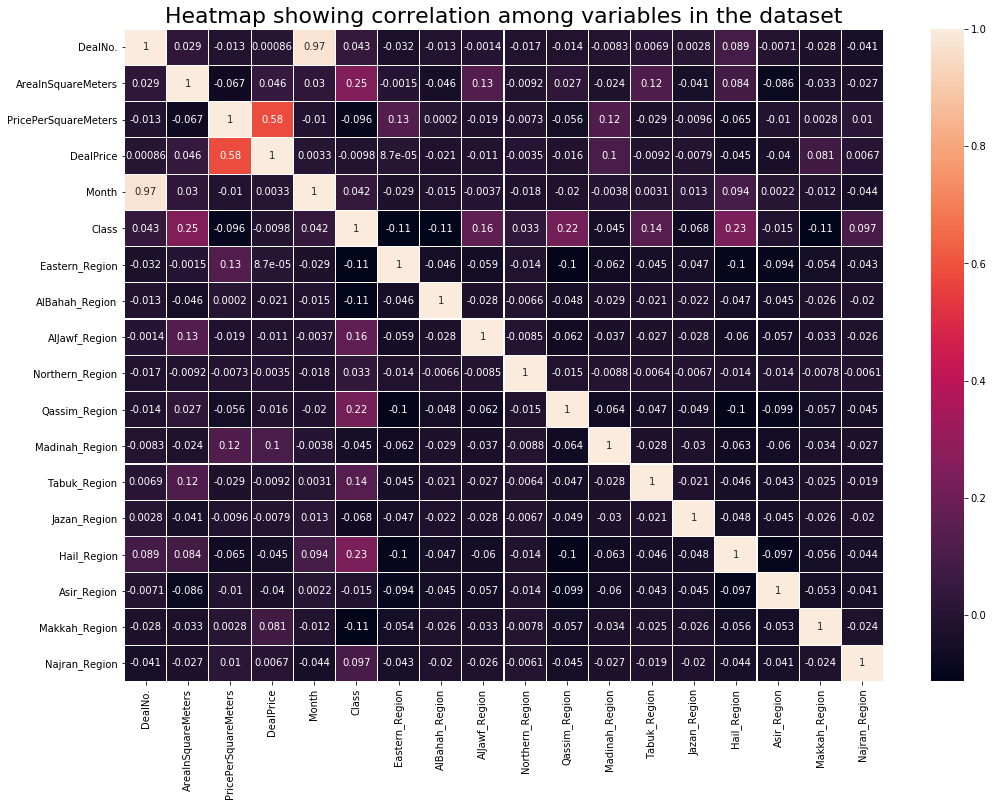

In [30]:
#  Examine the correlation among variables (Correlation matrix ranges from 1 to -1)
plt.figure(figsize=(17,12))
ax = sns.heatmap(df.corr(), annot=True, linewidth=0.1)
plt.yticks(rotation=0)
ax.set_title('Heatmap showing correlation among variables in the dataset', 
             fontsize=22, y=1.01);

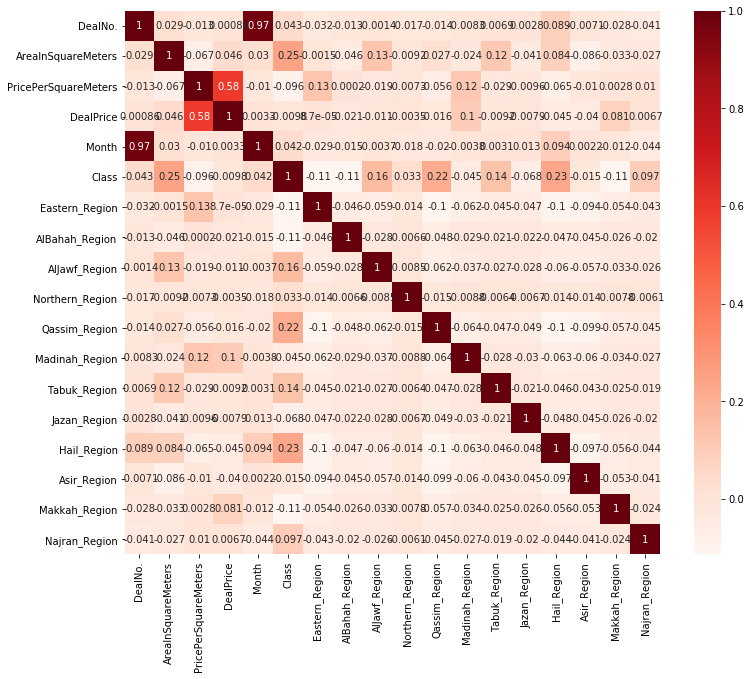

In [31]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [32]:
#Correlation with output variable
cor_target = abs(cor["DealPrice"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

PricePerSquareMeters    0.5837
DealPrice               1.0000
Name: DealPrice, dtype: float64

In [33]:
#Correlation with output variable
cor_target = abs(cor["PricePerSquareMeters"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

PricePerSquareMeters    1.0000
DealPrice               0.5837
Name: PricePerSquareMeters, dtype: float64

#### Plot the Distributions.

In [35]:
def distribution_plotter(column, data_set):
    data = data_set[column]
    sns.set(rc={"figure.figsize": (10, 7)})
    sns.set(color_codes=True)
    sns.set(style="white", palette="muted")
    dist = sns.distplot(data, fit=norm, kde=False, hist_kws={'alpha':0.2}, kde_kws={'linewidth':5})
    dist.set_title('Distribution of ' + column + '\n', fontsize=16)

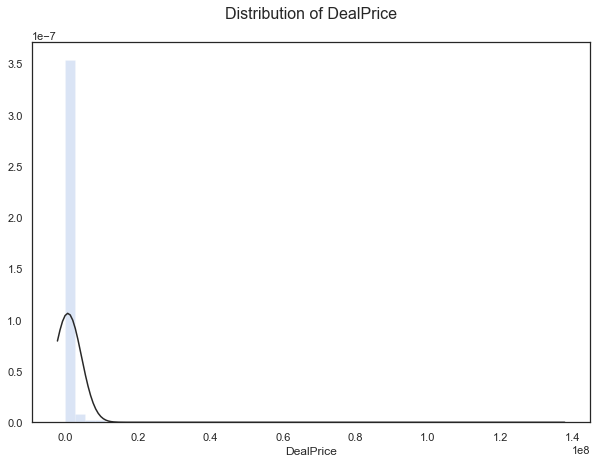

In [38]:
distribution_plotter('DealPrice', df)

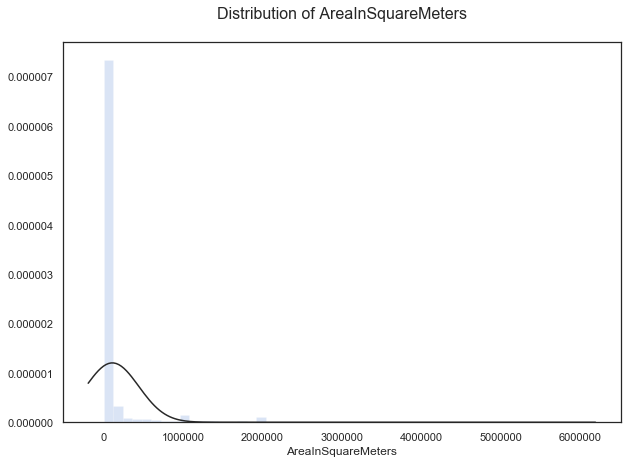

In [39]:
distribution_plotter('AreaInSquareMeters', df)

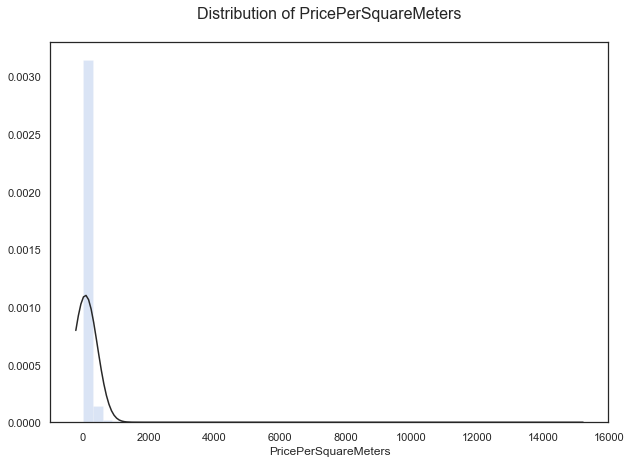

In [40]:
distribution_plotter('PricePerSquareMeters', df)

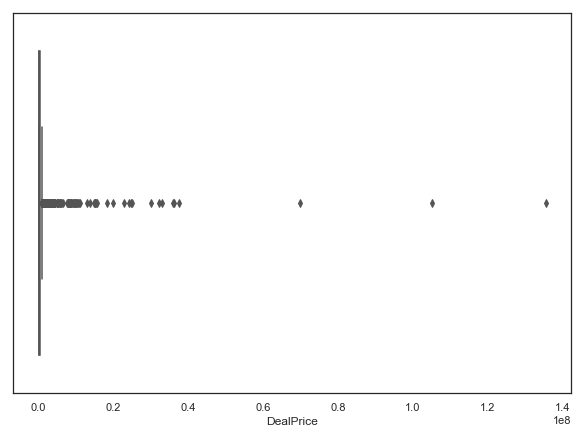

In [41]:
sns.boxplot(x=df['DealPrice']);

#### Skewness (Measure of the asymmetry of the distribution).

In [45]:
# check the skewness (asymmetry in the distribution) for all numeric features
for col in df._get_numeric_data():
    print(col,df[col].skew())

DealNo. 0.00951497306025
AreaInSquareMeters 5.6655051731508985
PricePerSquareMeters 27.838645617319898
DealPrice 23.101561893028354
Month 0.19306426323853804
Class 0.5743090844270617
Eastern_Region 2.887702338659269
AlBahah_Region 6.617603697060716
AlJawf_Region 5.1014676150853004
Northern_Region 22.319108776622155
Qassim_Region 2.735498545628027
Madinah_Region 4.880054636072043
Tabuk_Region 6.865285466852452
Jazan_Region 6.525211324080874
Hail_Region 2.8095501894490456
Asir_Region 3.010221401517804
Makkah_Region 5.575482681283795
Najran_Region 7.19920698059528


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


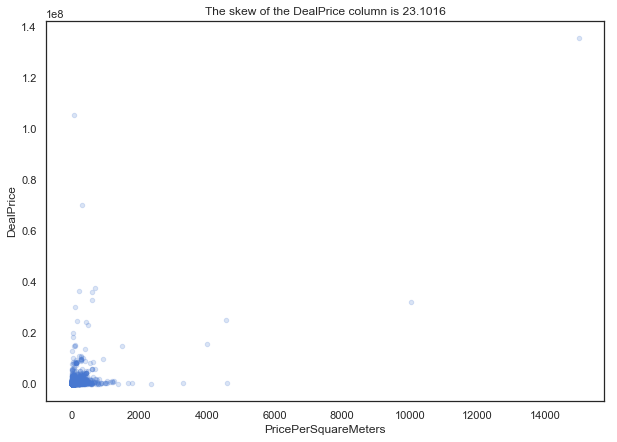

In [46]:
df.plot(kind='scatter', x='PricePerSquareMeters', y='DealPrice', alpha=0.2)
plt.title("The skew of the DealPrice column is {:.4f}".format(df['DealPrice'].skew()));

#### Kurtosis: (Measure of extreme risk “extreme outliers”)

In [47]:
# check the kurtosis (measure of extreme outliers) for all the numeric features
for col in df._get_numeric_data():
    print(col,df[col].kurt())

DealNo. -0.7989239989444465
AreaInSquareMeters 47.775718381882136
PricePerSquareMeters 1002.9209994045408
DealPrice 695.7646269821744
Month -1.2123530069544477
Class -1.671122966565977
Eastern_Region 6.342443554935825
AlBahah_Region 41.816539447688925
AlJawf_Region 24.03868830219519
Northern_Region 496.42588356907373
Qassim_Region 5.486082400132867
Madinah_Region 21.827387927627893
Tabuk_Region 45.15791192996744
Jazan_Region 40.601550291032545
Hail_Region 5.896936813108518
Asir_Region 7.065464209741542
Makkah_Region 29.10261314761823
Najran_Region 49.857029918216924


#### Box Plot of Numeric Features  to Check the Outliers.

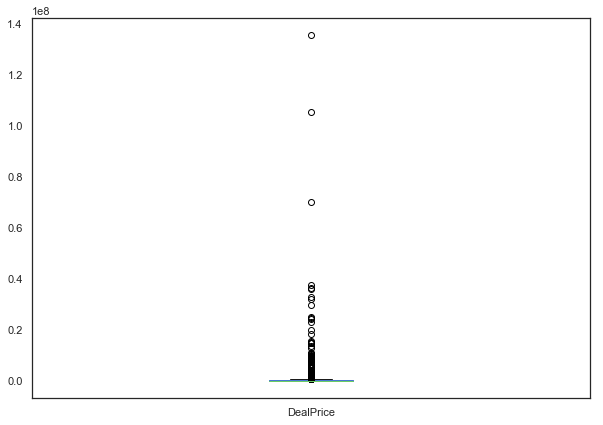

In [48]:
df['DealPrice'].plot(kind='box');

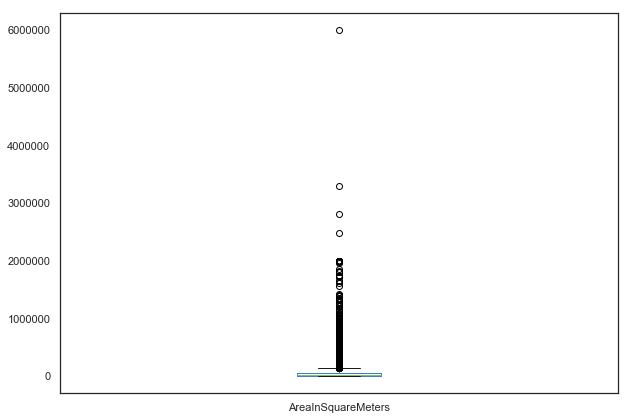

In [49]:
df['AreaInSquareMeters'].plot(kind='box')

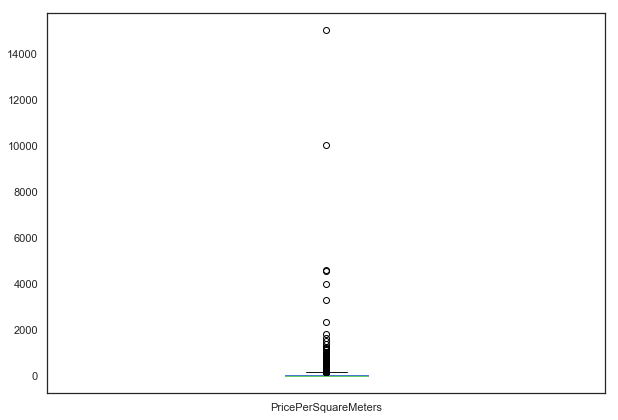

In [50]:
df['PricePerSquareMeters'].plot(kind='box')

In [51]:
# Check the lower percentile(25), 50 percentile(median) and upper percentile(75) values
pd.set_option('display.float_format', '{:.2f}'.format)
df["DealPrice"].describe()

count        3505.00
mean       682219.15
std       3751614.88
min         10000.00
25%         70000.00
50%        126000.00
75%        400000.00
max     135617150.00
Name: DealPrice, dtype: float64

In [52]:
# Check the lower percentile(25), 50 percentile(median) and upper percentile(75) values
pd.set_option('display.float_format', '{:.2f}'.format)
df["AreaInSquareMeters"].describe()

count      3505.00
mean     109544.07
std      332012.95
min          32.25
25%        3290.00
50%       10944.86
75%       54400.00
max     6000000.00
Name: AreaInSquareMeters, dtype: float64

In [53]:
# Check the lower percentile(25), 50 percentile(median) and upper percentile(75) values
pd.set_option('display.float_format', '{:.2f}'.format)
df["PricePerSquareMeters"].describe()

count    3505.00
mean       79.29
std       362.36
min         0.01
25%         1.80
50%        16.82
75%        62.13
max     15004.57
Name: PricePerSquareMeters, dtype: float64

### Detect and Remove the Outliers using IQR score 
The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1.

 “A convenient definition of a outlier is a point which falls more than 1.5 times the interquartile range above the third quartile or below the first quartile.” 

In [54]:
# Define a method to remove outliers
def remove_outlier(df, col):
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3 - q1
  lower_bound  = q1 - (1.5  * iqr)
  upper_bound = q3 + (1.5 * iqr)
  out_df = df.loc[(df[col] > lower_bound) & (df[col] < upper_bound)]
  return out_df

In [57]:
df = remove_outlier(df,"DealPrice")
df = remove_outlier(df,"PricePerSquareMeters")

In [56]:
df = remove_outlier(df,"AreaInSquareMeters")

#### Check the Skewness and Distributions after Removing the Outliers

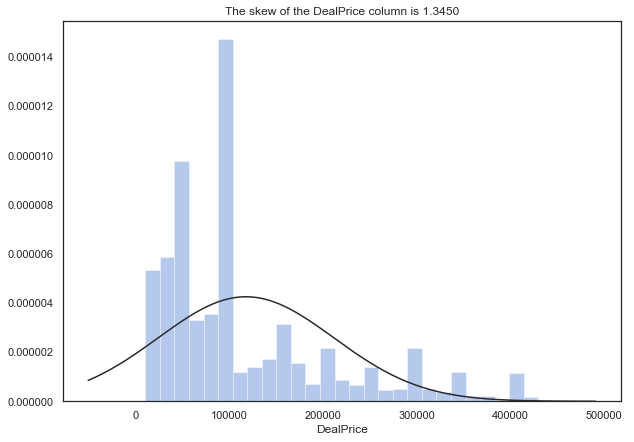

In [58]:
#check the target (DealPrice) after removing outliers
dist = sns.distplot(df.DealPrice, fit=norm, kde=False);
dist.set_title("The skew of the DealPrice column is {:.4f}".format(df['DealPrice'].skew()));

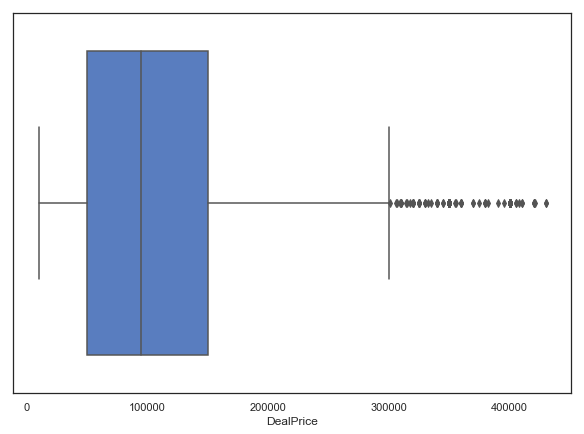

In [59]:
sns.boxplot(x=df['DealPrice']);

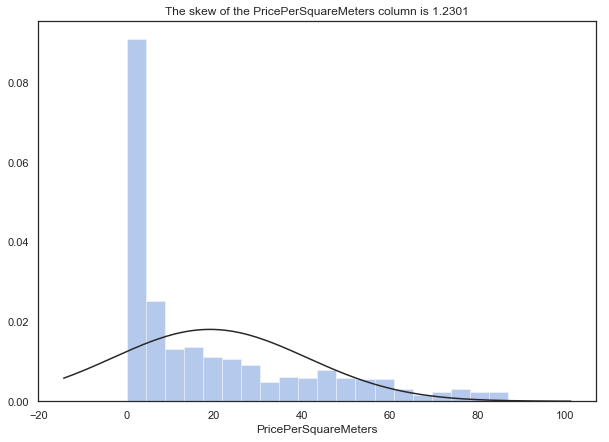

In [60]:
#check the X feature after removing outliers
dist = sns.distplot(df.PricePerSquareMeters, fit=norm, kde=False);
dist.set_title("The skew of the PricePerSquareMeters column is {:.4f}".format(df['PricePerSquareMeters'].skew()));

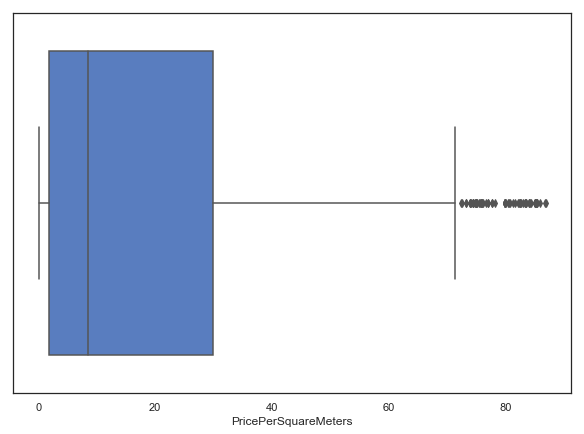

In [61]:
sns.boxplot(x=df['PricePerSquareMeters']);

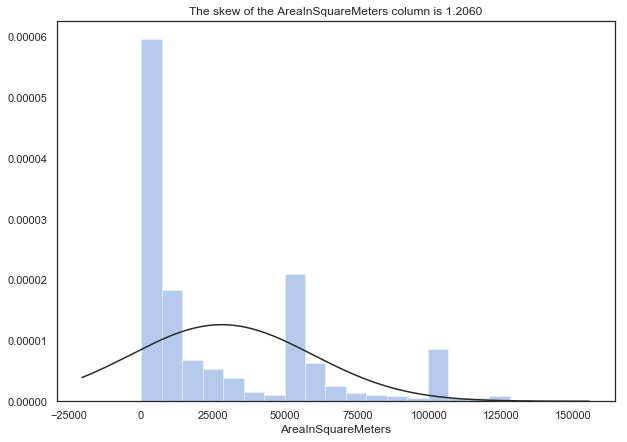

In [62]:
#check the X feature after removing outliers
dist = sns.distplot(df.AreaInSquareMeters, fit=norm, kde=False);
dist.set_title("The skew of the AreaInSquareMeters column is {:.4f}".format(df['AreaInSquareMeters'].skew()));

#### Scatter Chart

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


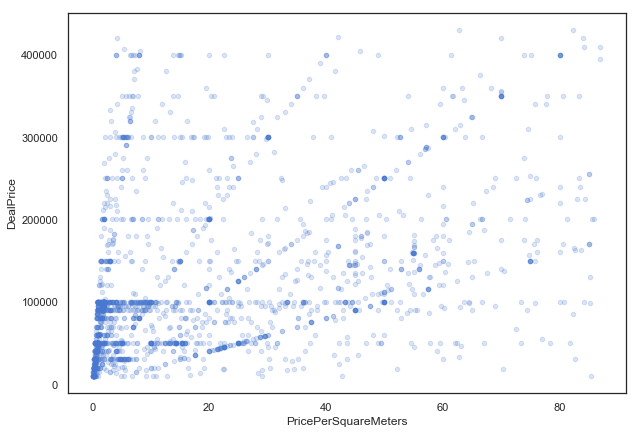

In [64]:
# Check the target & feature Scatter chart after removing outliers
df.plot(kind='scatter', x='PricePerSquareMeters', y='DealPrice', alpha=0.2);
#plt.title("The skew of the DealPrice column is {:.4f}".format(df['DealPrice'].skew()));

#### `DataFrame` Shape after Removing the Outliers.

In [66]:
# Check dataframe shape (n = number of observations, p = number of features).
print((df.shape))

(2105, 25)


#### Box Plot the Target variable, grouping by other features

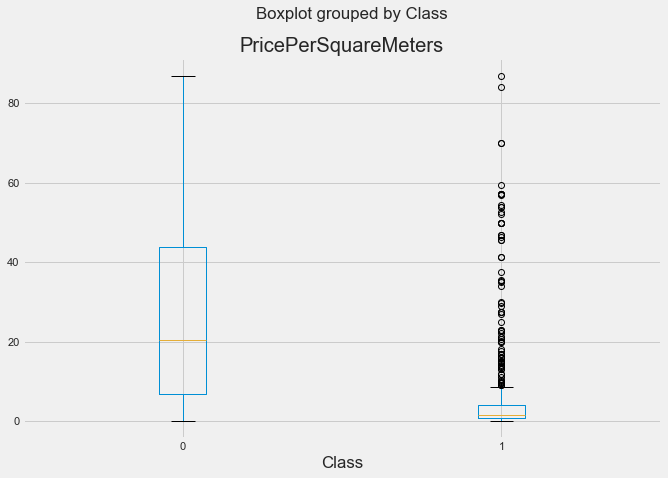

In [164]:
# Box plot of deal prices, grouped by Class.
df.boxplot(column='PricePerSquareMeters', by='Class')
plt.tight_layout(rect=[0, 0.03, 0.95, 0.95]);

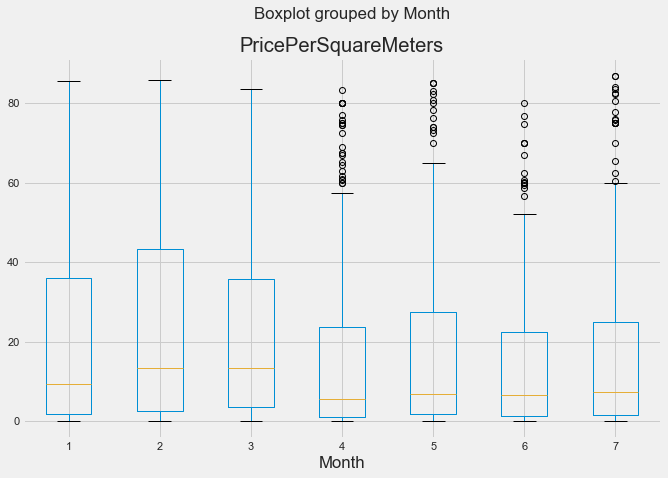

In [165]:
# Box plot of deal prices, grouped by Month.
df.boxplot(column='PricePerSquareMeters', by='Month')
plt.tight_layout(rect=[0, 0.03, 0.95, 0.95]);

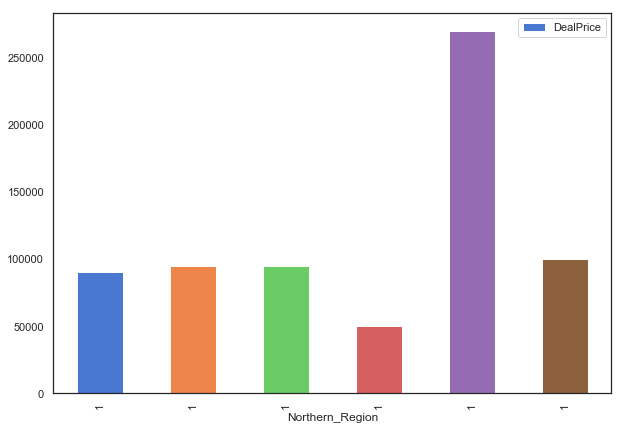

In [69]:
df[df['Northern_Region']==1].plot(kind='bar',x='Northern_Region',y='DealPrice')


In [71]:
#df.plot(column='DealPrice', by='Region', kind='barh')
#plt.tight_layout(rect=[0, 0.03, 0.95, 0.95]);

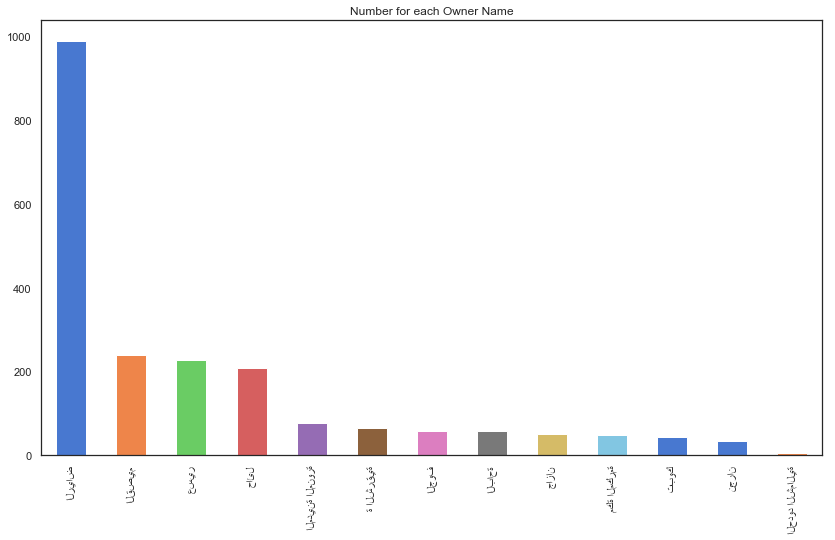

In [72]:
ax = df['Region'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number for each Owner Name")

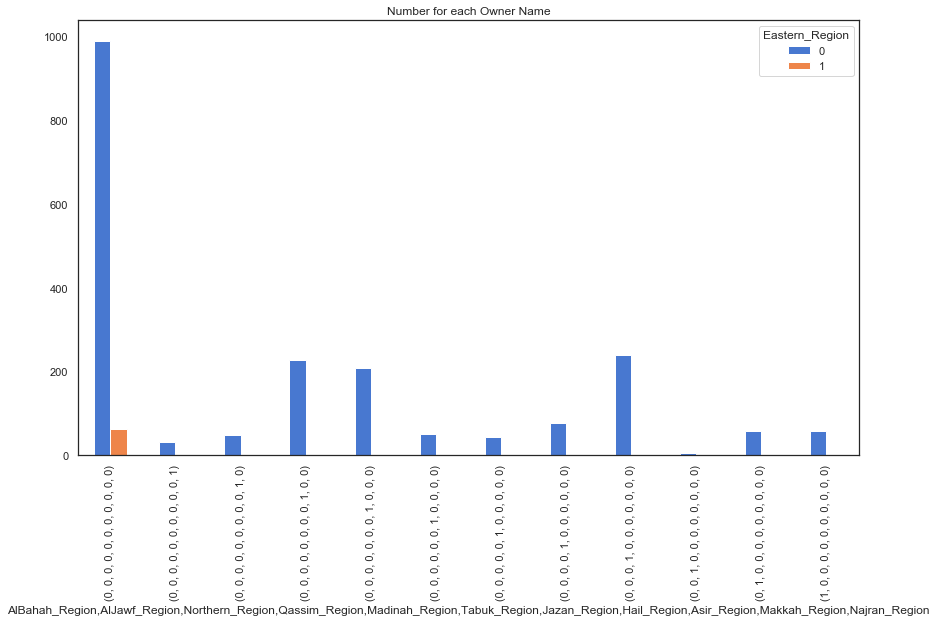

In [73]:
ax = df.groupby(['Eastern_Region','AlBahah_Region','AlJawf_Region','Northern_Region','Qassim_Region','Madinah_Region','Tabuk_Region','Jazan_Region','Hail_Region','Asir_Region','Makkah_Region','Najran_Region'])['DealPrice'].count().unstack(0).plot.bar(title="Number for each Owner Name", figsize=(14,8))


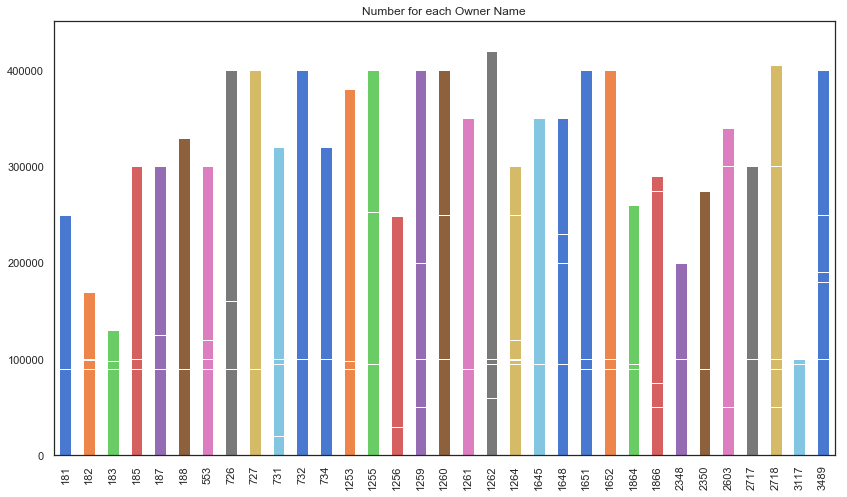

In [74]:
ax = df.groupby(['Region'])['DealPrice'].plot.bar(title="Number for each Owner Name", figsize=(14,8))


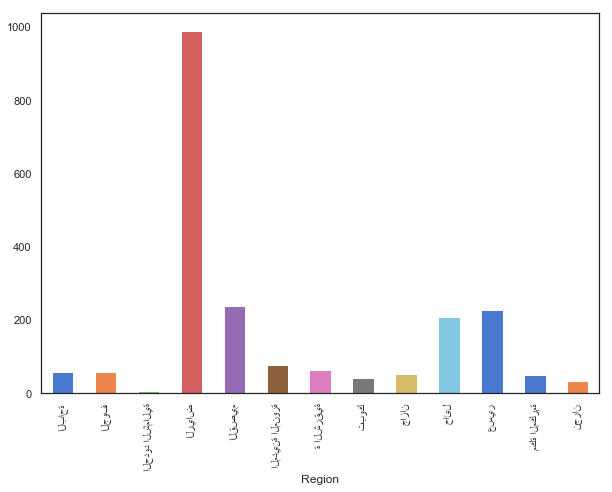

In [75]:
#Number of unique deals per region
df.groupby('Region')['DealNo.'].nunique().plot(y='DealPrice', kind='bar')
plt.show()

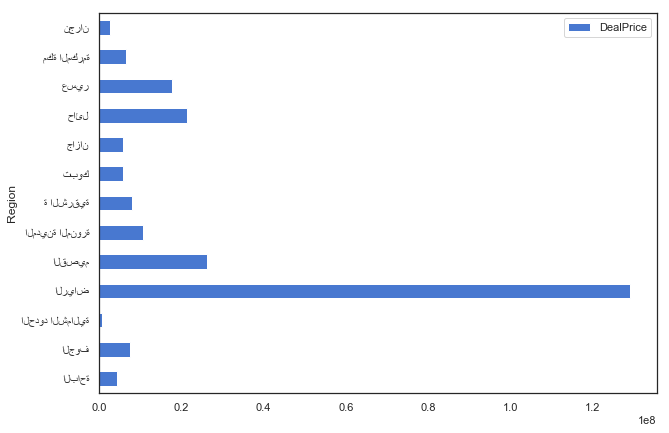

In [76]:
#let’s find what region sold the most agricultural land
df[['Region', 'DealPrice']].groupby('Region').sum().plot(kind='barh' );

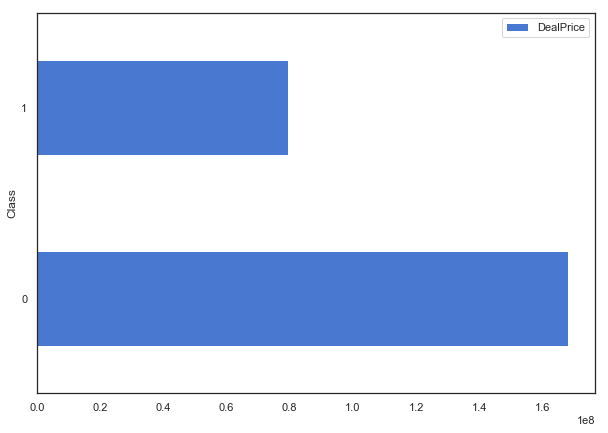

In [77]:
df[['Class', 'DealPrice']].groupby('Class').sum().plot(kind='barh')

In [78]:
ax = df.groupby(['Class'])['DealPrice']

In [79]:
gk=df.groupby('Region')['DealPrice']

In [80]:
gk.first()

Region
الباحة              30000
الجوف               10000
الحدود الشمالية     90000
الرياض              99000
القصيم              60000
المدينة المنورة     90000
ة الشرقية           13000
تبوك                80000
جازان              100000
حائل                35000
عسير                95000
مكة المكرمة        250000
نجران               90000
Name: DealPrice, dtype: int64

In [81]:
df[(df['Eastern_Region']==1) & (df['AlBahah_Region']==1)& (df['AlJawf_Region']==1)& (df['Northern_Region']==1)& (df['Qassim_Region']==1)& (df['Madinah_Region']==1)& (df['Tabuk_Region']==1)& (df['Jazan_Region']==1)& (df['Hail_Region']==1)& (df['Asir_Region']==1)& (df['Makkah_Region']==1)& (df['Najran_Region']==1)]

,Region,City,AreaName,BlockNo.,LotNo.,Classification,DealDate,DealNo.,AreaInSquareMeters,PricePerSquareMeters,...,AlJawf_Region,Northern_Region,Qassim_Region,Madinah_Region,Tabuk_Region,Jazan_Region,Hail_Region,Asir_Region,Makkah_Region,Najran_Region


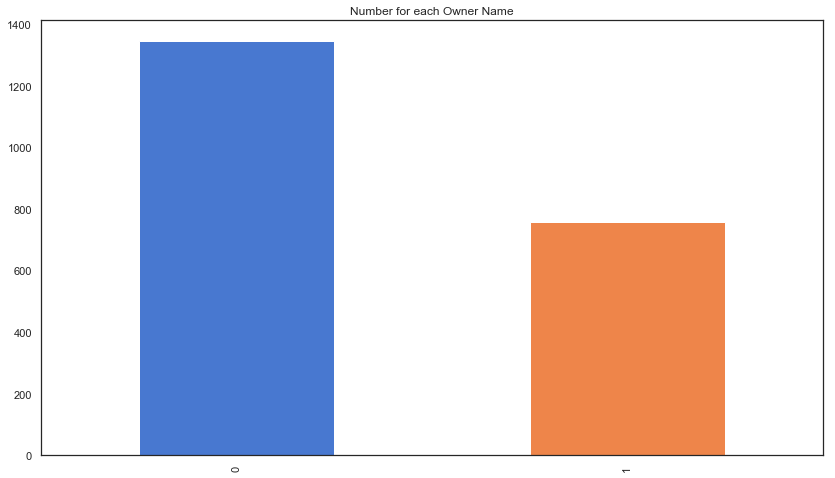

In [82]:
ax = df['Class'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number for each Owner Name")

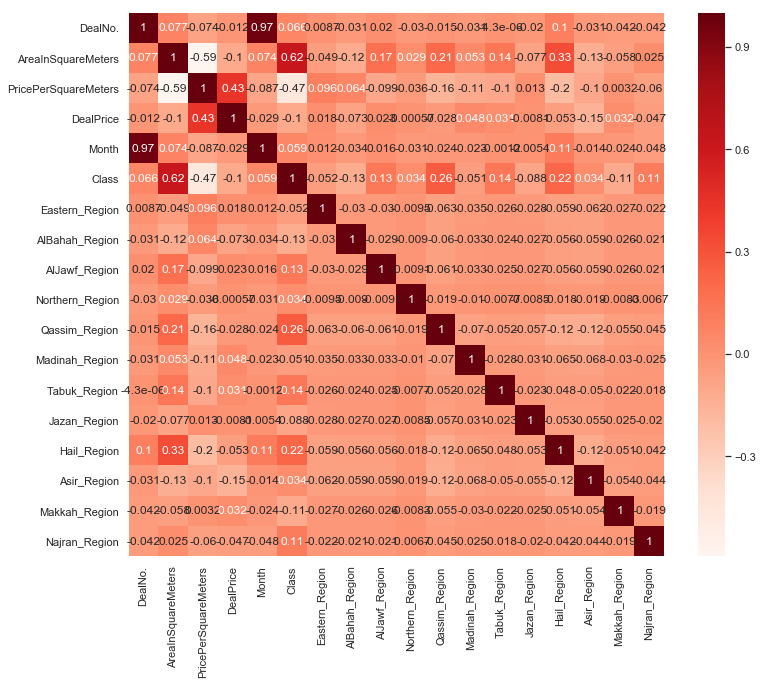

In [86]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### Correlation Matrix of the `DataFrame`

In [100]:
# Correlation matrix (ranges from 1 to -1)
df.corr().style

,DealNo.,AreaInSquareMeters,PricePerSquareMeters,DealPrice,Month,Class,Eastern_Region,AlBahah_Region,AlJawf_Region,Northern_Region,Qassim_Region,Madinah_Region,Tabuk_Region,Jazan_Region,Hail_Region,Asir_Region,Makkah_Region,Najran_Region
DealNo.,1,0.076622,-0.0735393,-0.0115738,0.973553,0.0656976,0.00874011,-0.0314006,0.020206,-0.0302644,-0.0148273,-0.0309749,-4.30222e-06,-0.0200819,0.101946,-0.0305133,-0.0422087,-0.0418384
AreaInSquareMeters,0.076622,1,-0.594094,-0.103696,0.0744202,0.615884,-0.049071,-0.120702,0.173805,0.0293739,0.205862,0.053093,0.135277,-0.0769389,0.331368,-0.131561,-0.0584042,0.0248274
PricePerSquareMeters,-0.0735393,-0.594094,1,0.434002,-0.0871961,-0.473121,0.0955668,0.0642384,-0.0992814,-0.0362585,-0.16171,-0.114445,-0.101646,0.0130132,-0.201716,-0.101744,0.00316225,-0.0598547
DealPrice,-0.0115738,-0.103696,0.434002,1,-0.0289376,-0.102885,0.018486,-0.0727349,0.0225299,-0.00056541,-0.0279698,0.0476192,0.0309712,-0.00814811,-0.0525289,-0.147184,0.03199,-0.0466806
Month,0.973553,0.0744202,-0.0871961,-0.0289376,1,0.0588982,0.0117331,-0.0335527,0.0155289,-0.0312775,-0.0238095,-0.0227681,-0.00124934,-0.00543178,0.113211,-0.0142227,-0.0243994,-0.04798
Class,0.0656976,0.615884,-0.473121,-0.102885,0.0588982,1,-0.0523016,-0.126402,0.130232,0.0340829,0.264528,-0.0514579,0.136353,-0.0876403,0.215509,0.0343504,-0.109366,0.112308
Eastern_Region,0.00874011,-0.049071,0.0955668,0.018486,0.0117331,-0.0523016,1,-0.0298074,-0.0300706,-0.00946756,-0.0633741,-0.0345048,-0.0255716,-0.0281823,-0.0586363,-0.0617169,-0.0273373,-0.0223476
AlBahah_Region,-0.0314006,-0.120702,0.0642384,-0.0727349,-0.0335527,-0.126402,-0.0298074,1,-0.0285843,-0.00899963,-0.0602418,-0.0327994,-0.0243078,-0.0267894,-0.0557382,-0.0586665,-0.0259861,-0.0212431
AlJawf_Region,0.020206,0.173805,-0.0992814,0.0225299,0.0155289,0.130232,-0.0300706,-0.0285843,1,-0.0090791,-0.0607738,-0.0330891,-0.0245224,-0.0270259,-0.0562304,-0.0591846,-0.0262156,-0.0214306
Northern_Region,-0.0302644,0.0293739,-0.0362585,-0.00056541,-0.0312775,0.0340829,-0.00946756,-0.00899963,-0.0090791,1,-0.0191343,-0.0104179,-0.00772075,-0.00850896,-0.0177038,-0.0186339,-0.00825384,-0.00674732


### 3. Modeling
#### Building  Regression Models in sklearn

In [101]:
# Create x and y 
#feature_cols = ['PricePerSquareMeters','AreaInSquareMeters','Class','Month','Eastern_Region','AlBahah_Region','AlJawf_Region','Northern_Region','Qassim_Region','Madinah_Region','Tabuk_Region','Jazan_Region','Hail_Region','Asir_Region','Makkah_Region','Najran_Region']
feature_cols = ['AreaInSquareMeters','Class','Month','Eastern_Region','AlBahah_Region','AlJawf_Region','Northern_Region','Qassim_Region','Madinah_Region','Tabuk_Region','Jazan_Region','Hail_Region','Asir_Region','Makkah_Region','Najran_Region']
x = df[feature_cols]
y = df.PricePerSquareMeters  

In [105]:
# Check x's type.
print((type(x)))
print((type(x.values)))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [106]:
# Check y's type.
print((type(y)))
print((type(y.values)))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


In [107]:
# Check x's shape (n = number of observations, p = number of features).
print((x.shape))

(2105, 15)


In [108]:
# Check y's shape (single dimension with length n).
# The comma indicates the datatype is a tuple.
print((y.shape))

(2105,)


#### Multiple scatterplots

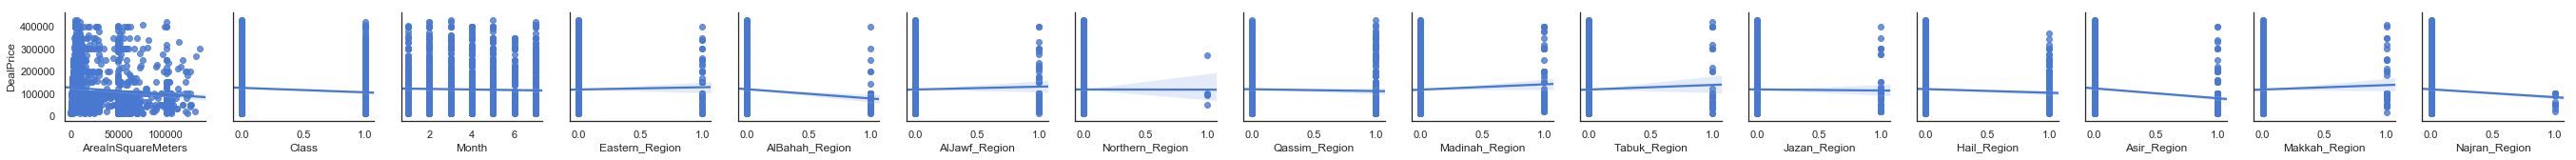

In [111]:
# Multiple scatterplots in Seaborn
sns.pairplot(df, x_vars=feature_cols, y_vars='DealPrice', kind='reg');

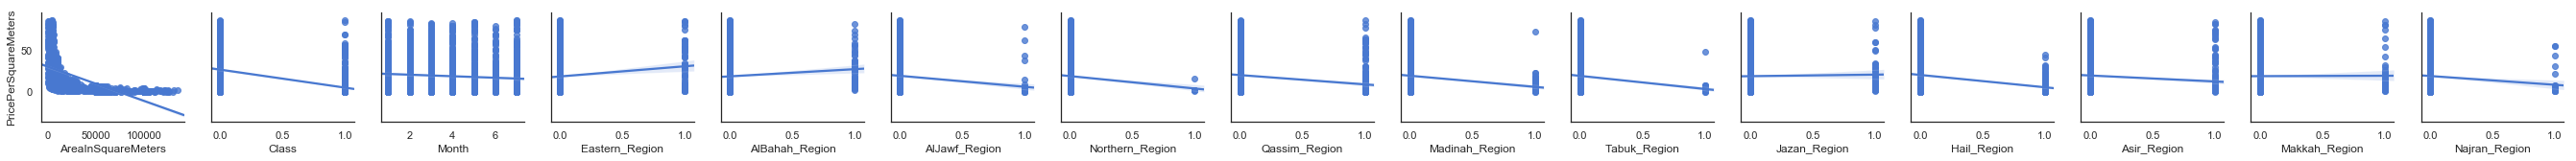

In [112]:
# Multiple scatterplots in Seaborn
sns.pairplot(df, x_vars=feature_cols, y_vars='PricePerSquareMeters', kind='reg');

### Train/Test Split

In [113]:
# Split x features and y into random train and test subsets
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2, random_state=42)

### Balanced Dataset
Making sure the train and test datasets have almost equal number in terms of:
    - Property classification type ( either 0 or 1)
    - Deals per month (1,2,3,4,5,6,7)

In [114]:
# Check the length of the resulted subsets
print(len(x_train))
print(len(y_train))
print()
print(len(x_test))
print(len(y_test))

1684
1684

421
421


In [115]:
# Making sure that each subset has similar number of property classification type (0/1)
print(x_train.Class.value_counts(normalize=True).mul(100))
print(x_test.Class.value_counts(normalize=True).mul(100))

0   64.25
1   35.75
Name: Class, dtype: float64
0   62.71
1   37.29
Name: Class, dtype: float64


In [116]:
# Making sure that each subset has similar number of Deals par month (1,2,3,4,5,6,7)
print(x_train.Month.value_counts(normalize=True).mul(100))
print(x_test.Month.value_counts(normalize=True).mul(100))

3   17.58
7   17.46
1   16.21
4   14.37
2   14.25
5   11.70
6    8.43
Name: Month, dtype: float64
7   21.62
2   16.86
1   16.15
3   13.78
4   13.06
5   11.64
6    6.89
Name: Month, dtype: float64


In [117]:
# Check the lower percentile(25), 50 percentile(median) and upper percentile(75) values for the target variable per classification type
print(df[df.Class == 1]['DealPrice'].describe())
print()
print(df[df.Class == 0]['DealPrice'].describe())

count      759.00
mean    104755.89
std      92905.64
min      10000.00
25%      43500.00
50%      85944.00
75%     100000.00
max     420000.00
Name: DealPrice, dtype: float64

count     1346.00
mean    124884.60
std      93813.10
min      10000.00
25%      50000.00
50%     100000.00
75%     162500.00
max     430000.00
Name: DealPrice, dtype: float64


#### The Regression Line
Examine the relation between the dependent variable and one of the the independent variables

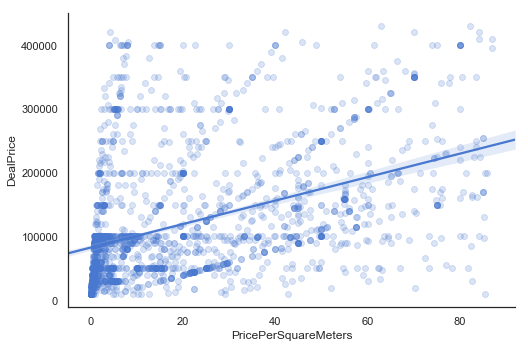

In [118]:
# Seaborn scatterplot with regression line
sns.lmplot(x='PricePerSquareMeters', y='DealPrice', data=df, aspect=1.5, scatter_kws={'alpha':0.2});

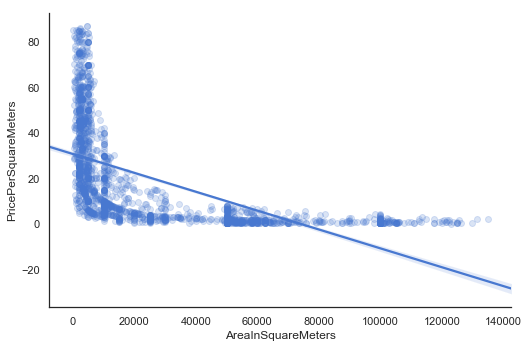

In [119]:
# Seaborn scatterplot with regression line
sns.lmplot(x='AreaInSquareMeters', y='PricePerSquareMeters', data=df, aspect=1.5, scatter_kws={'alpha':0.2});

## Challenge:

#### Linear regression:
`Linear regression` requires the relation between the dependent variable and the independent variable to be linear. However, the features in the current dataset has a slight non-linear variation with the target variable.

Since the distribution of the features is more complex and linear models cannot be used to fit non-linear, I was unable to capture the patterns in the data which led to large errors (under-fitting)



#### PolynomialFeatures:
To overcome under-fitting, I needed to increase the complexity of the model by applying `Polynomial regression` in order to generate a curve that best captures the data.

##### Best Practice:

1- Apply `Polynomial regression` to transform the original features into higher degree polynomials before training the model.

2- Apply `Linear Regression` 

### Applying Polynomial Regression

In [120]:
# Generate a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree.
poly_features= PolynomialFeatures(degree=2)

# transforms the existing features to higher degree features.
x_train_poly = poly_features.fit_transform(x_train)
x_test_poly = poly_features.fit_transform(x_test)

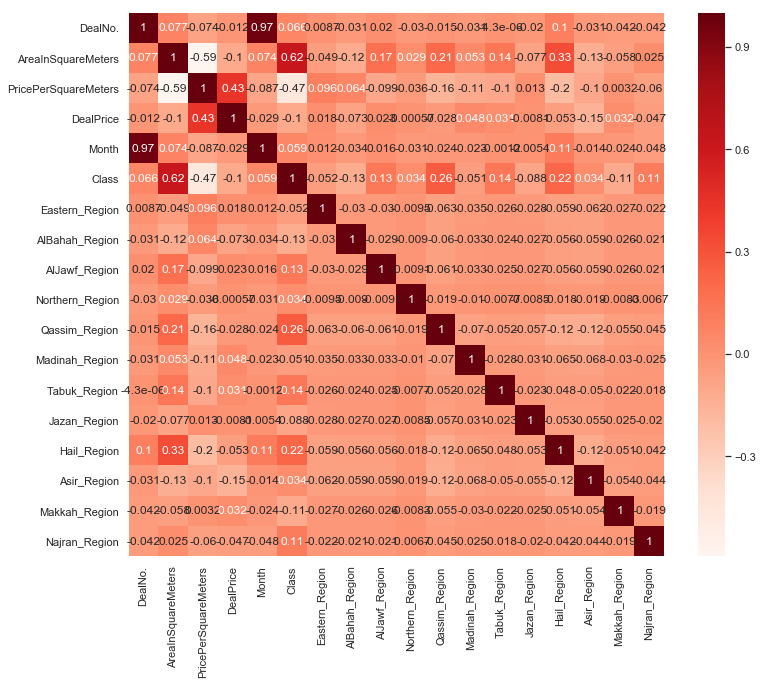

In [121]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### Applying Linear Regression

#### Instantiate and fit a `LinearRegression` model on x and y from the `linear_model` section of scikit-learn.

In [122]:
# Instantiate (Make an instance of a LinearRegression object) and fit the transformed features to Linear Regression
lr = LinearRegression()
lr.fit(x_train_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

#### Interpreting the intercept ($\beta_0$):

- It is the value of $y$ when all independent variables are 0.
- Here, it is the estimated number of `DealPrice` when all independent variables are 0.


#### Display the linear regression coefficient along with the feature names.

In [123]:
# Print the coefficients
from tabulate import tabulate
col_names = ["Feature_name", "coefficient"]
coefficients = sorted(zip(feature_cols, lr.coef_), key=lambda x: x[1] * -1)
print(tabulate(coefficients, col_names, floatfmt='.4f'))

Feature_name          coefficient
------------------  -------------
AlBahah_Region             1.1108
Northern_Region            0.9364
Jazan_Region               0.6363
AreaInSquareMeters         0.0000
Class                     -0.0012
Hail_Region               -0.1023
AlJawf_Region             -0.2891
Month                     -0.7861
Najran_Region             -0.7972
Eastern_Region            -2.2923
Madinah_Region            -3.6896
Qassim_Region             -4.1516
Makkah_Region             -5.5953
Asir_Region               -7.5160
Tabuk_Region              -8.0561


### Using the Model for Prediction

In [124]:
# Using the Model for Prediction
y_lr_pred = lr.predict(x_test_poly)

In [125]:
print("Intercept:", lr.intercept_)
#print("Linear Regression coefficients:", linear.coef_)

#Calculate the SSE 0.2760304507274931
print("SSE:", sum(np.square(y_lr_pred - y_test)))

Intercept: 46.39142893355857
SSE: 87288.40476454537


In [126]:
# Linear metrics
from sklearn import metrics
import numpy as np
print('MAE:', metrics.mean_absolute_error(y_test, y_lr_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_lr_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_lr_pred)))
print('R2 score:', metrics.r2_score(y_test, y_lr_pred))
print('Mean absolute percentage error (MAPE):', np.mean(np.abs((y_test - y_lr_pred) / y_test)) * 100)

MAE: 10.145891661005336
MSE: 207.33587830058278
RMSE: 14.399162416633224
R2 score: 0.5418239238247964
Mean absolute percentage error (MAPE): 269.09470846054614


###### RMSE would be about 577743, indicating that pur model misses actual sale valuea by about SAR 141745.1 M (M is the unit of output)
###### MAPE States that our model's predictions are, on average, 119.9%  (far) off from actual value

**Interpreting Metrics:**
By applying the `Polynomial Regression`, we can see that RMSE has decreased and R²-score has increased 

In [127]:
# RMSE for train and test sets should be similar when building a good model, If RMSE test> RMSE train then it's overfit
y_train_pred = lr.predict(x_train_poly)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_train_pred)))

RMSE: 15.110736470197402


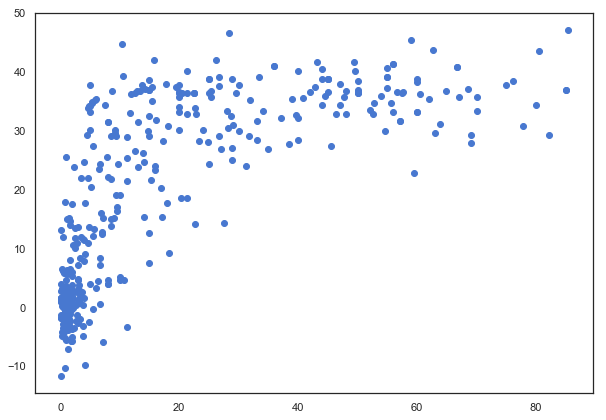

In [128]:
plt.scatter(y_test, y_lr_pred);
##plt.ylim([200000,1000000])
##plt.xlim([200000,1000000])

C:\Users\hsalamah\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


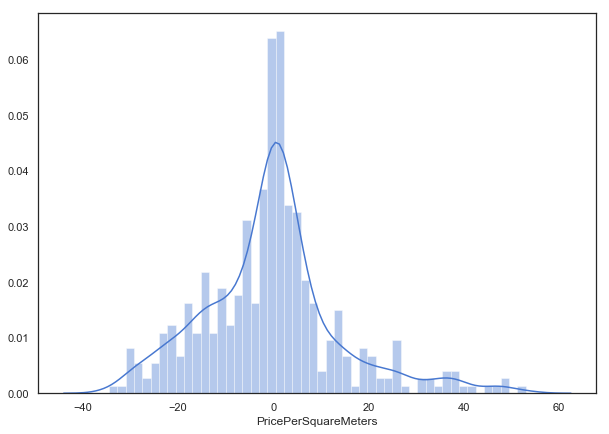

In [129]:
sns.distplot((y_test-y_lr_pred),bins=50);

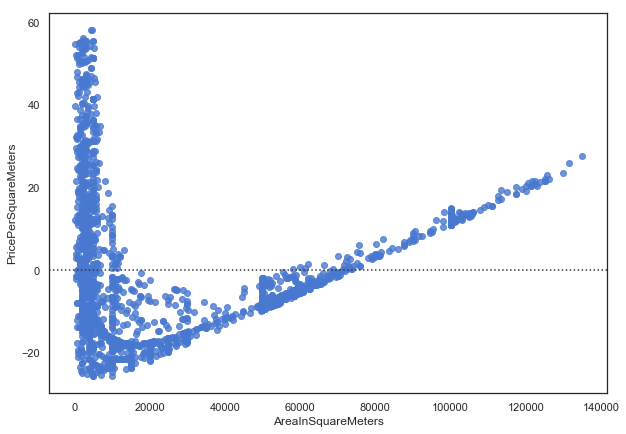

In [130]:
sns.residplot(x= 'AreaInSquareMeters', y= 'PricePerSquareMeters', data= df)

### Plot the Risdual Error

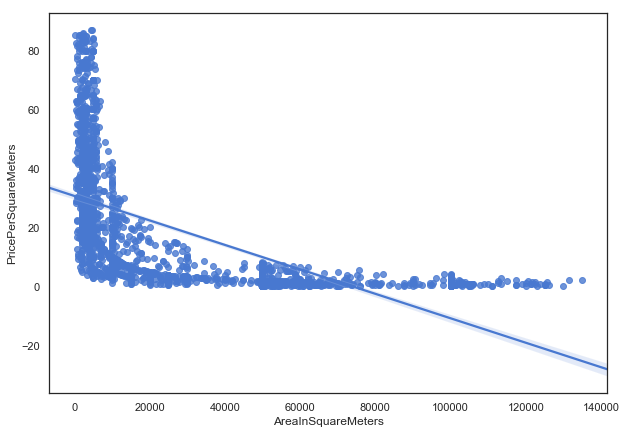

In [131]:
sns.regplot(x= 'AreaInSquareMeters', y= 'PricePerSquareMeters', data= df)

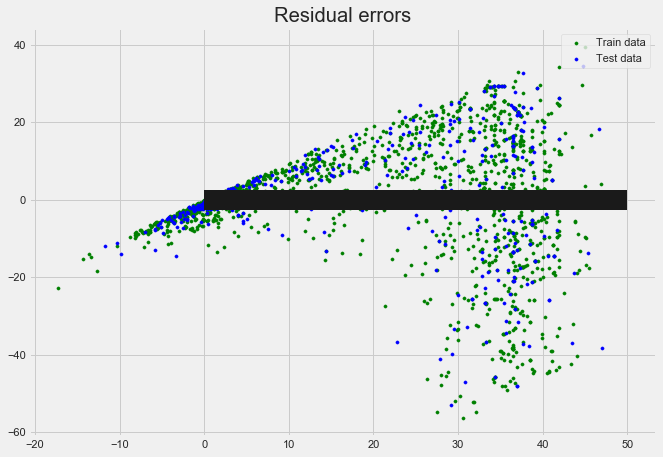

In [132]:
# plot for residual error 
  
# setting plot style 
plt.style.use('fivethirtyeight') 
  
# plotting residual errors in training data 
plt.scatter(lr.predict(x_train_poly), lr.predict(x_train_poly) - y_train, 
            color = "green", s = 10, label = 'Train data') 
  
# plotting residual errors in test data 
plt.scatter(lr.predict(x_test_poly), lr.predict(x_test_poly) - y_test, 
            color = "blue", s = 10, label = 'Test data') 
  
# plotting line for zero residual error 
plt.hlines(y = 0, xmin = 0, xmax = 50, linewidth = 20) 
  
# plotting legend 
plt.legend(loc = 'upper right') 
  
# plot title 
plt.title("Residual errors") 
  
# function to show plot 
plt.show() 

#### Residual Plot

Residual plot helps in analyzing the model using the values of residues. It is plotted between predicted values and residue. Their values are standardized. The distance of the point from 0 specifies how bad the prediction was for that value. If the value is positive, then the prediction is low. If the value is negative, then the prediction is high. 0 value indicates prefect prediction. Detecting residual pattern can improve the model.

Text(0, 0.5, 'Residual')

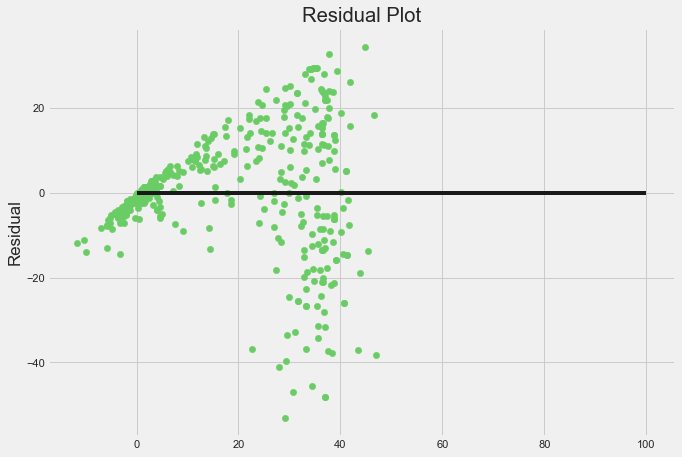

In [133]:
#Residual Plot
plt.scatter(y_lr_pred,y_lr_pred - y_test, c='g', s=40);
plt.hlines(y=0,xmin=0,xmax=100);
plt.title("Residual Plot")
plt.ylabel("Residual")

### Compare Actual and Predicted Values

In [134]:
# Save the Actual target in a new DataFrame
df_out = pd.DataFrame(y_test)

In [135]:
# Add the Predicted Variable to the new DataFrame
df_out['pred_PricePerSquareMeters'] = y_lr_pred

In [136]:
df_out

,PricePerSquareMeters,pred_PricePerSquareMeters
2443,15.00,36.91
574,0.84,1.33
1642,18.14,30.73
3335,4.17,-9.87
2274,1.64,2.44
2802,66.96,35.63
224,50.00,38.50
559,8.74,36.70
1677,0.77,0.51
2731,0.84,-0.18


In [137]:
# Save the results in new csv file
df_out.to_csv("PricePerSquareMeterActualVsPredicted.csv")

In [138]:
# from sklearn.preprocessing import PolynomialFeatures

# polynomial_features= PolynomialFeatures(degree=2)
# x_poly = polynomial_features.fit_transform(x)

# x_train,x_test,y_train,y_test=train_test_split(x_poly,y,test_size=0.2, random_state=42)

# # print(len(x_test))
# print(len(y_test))

### Building Other Regression Models

In [139]:
# Huber Regression
huber = HuberRegressor()
huber.fit(x_train_poly, y_train)
huber_score = huber.score(x_train_poly, y_train) 

y_huber_pred = huber.predict(x_test_poly)

print(huber.intercept_)
#print("True coefficients:", coef)
#print("Huber coefficients:", huber.coef_)

4.40011447594142e-19


In [140]:
# Ransac Regression
ransac = RANSACRegressor(random_state=0)
ransac.fit(x_train_poly, y_train)
ransac_score = ransac.score(x_train_poly, y_train)
y_ransac_pred = ransac.predict(x_test_poly)
print("RANSAC Score:",ransac_score )

RANSAC Score: 0.35369849062305464


In [141]:
# Theil-Sen Regression
TheilSen = TheilSenRegressor(random_state=0)
TheilSen.fit(x_train_poly, y_train)
TheilSen_score = TheilSen.score(x_train_poly, y_train)
y_TheilSen_pred = TheilSen.predict(x_test_poly)

print("TheilSen Score:",TheilSen_score )
print(TheilSen.intercept_)
#print("TheilSen coefficients:", TheilSen.coef_)

TheilSen Score: 0.5157162582422086
23.37128859414435


In [142]:
# Ridge Regression
ridge = Ridge(alpha=0.01) # OR rr = RidgeCV(alphas=[0.1, 1.0, 10.0])
# higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely
# restricted and in this case linear and ridge regression resembles
ridge.fit(x_train_poly, y_train)
# rr.alpha_
y_ridge_pred = ridge.predict(x_test_poly)

print(ridge.intercept_)

#print("Ridge coefficients:", ridge.coef_)

46.39043007728985


C:\Users\hsalamah\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.065486e-25
  overwrite_a=True).T


In [143]:
# Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(x_train_poly, y_train)

y_lasso_pred = lasso.predict(x_test_poly)

print(lasso.intercept_)
#print("Lasso Regression coefficients:", lasso.coef_)

43.956178275162074


In [144]:
# Support Vector Regression
svr=SVR(kernel='rbf',degree=1) #try poly
svr.fit(x_train_poly, y_train)
y_svr_pred = svr.predict(x_test_poly)

# Print the coefficients.
print(svr.intercept_)
#print("Linear Regression coefficients:", svreg.coef_)

C:\Users\hsalamah\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[8.63487628]


In [145]:
# ridge_reg = Ridge(alpha=0)
# ridge_reg.fit(x_train, y_train)
# #ridge_train_pred = []
# ridge_test_pred = []

# # iterate lambdas
# for alpha in np.arange(0, 200, 1):
#     # training
#     ridge_reg = Ridge(alpha=alpha)
#     ridge_reg.fit(x_train, y_train)
#     y_ridgepred= ridge_reg.predict(x_test)
    

# print(ridge_reg.intercept_)
# print("Ridge coefficients:", ridge_reg.coef_)

In [146]:
# K-Nearest Neighbors Regression
neigh = KNeighborsRegressor()
neigh.fit(x_train_poly, y_train)
y_neigh_pred = neigh.predict(x_test_poly)

In [147]:
# Decision Tree Regression
dtree = DecisionTreeRegressor(random_state=0)
dtree.fit(x_train_poly, y_train)

y_dtree_pred = dtree.predict(x_test_poly)

In [148]:
# Random Forest Regression
rf = RandomForestRegressor(random_state=0)
rf.fit(x_train, y_train)

y_rf_pred = rf.predict(x_test)
print(rf.feature_importances_)


# from tabulate import tabulate
# col_names = ["Feature_name", "feature Importance"]
# coefficients = sorted(zip(feature_cols, rfreg.feature_importances_))
# print(tabulate(coefficients, col_names))


[8.52474644e-01 1.50542502e-02 6.63805038e-02 8.68276591e-03
 9.48915465e-03 1.55292499e-03 2.59899194e-05 7.32213940e-03
 8.61257578e-04 1.90689631e-03 6.25883847e-03 3.11575924e-03
 1.80524832e-02 8.03887524e-03 7.83517467e-04]


C:\Users\hsalamah\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Evaluation Metrics for Other Models

In [149]:
def get_metrics(y_true, y_hat):
        print('MAE:', round(metrics.mean_absolute_error(y_true, y_hat), 3))
        print('MedAE:', round(metrics.median_absolute_error(y_true, y_hat), 3))
        print('MSE:', round(metrics.mean_squared_error(y_true, y_hat), 3))
        print('RMSE:', round(metrics.mean_squared_error(y_true, y_hat) ** 0.5, 3))
        print('R2 Score:', round(metrics.r2_score(y_true, y_hat), 3))
        print('MAPE:', np.mean(np.abs((y_true - y_hat) / y_true)) * 100)

In [150]:
# Linear metrics
get_metrics(y_test, y_lr_pred)

MAE: 10.146
MedAE: 6.264
MSE: 207.336
RMSE: 14.399
R2 Score: 0.542
MAPE: 269.09470846054614


In [151]:
# Huber metrics
get_metrics(y_test, y_huber_pred)

MAE: 17.055
MedAE: 6.455
MSE: 746.93
RMSE: 27.33
R2 Score: -0.651
MAPE: 109.43215545609408


In [152]:
# RANSAC metrics
get_metrics(y_test, y_ransac_pred)

MAE: 12.286
MedAE: 6.625
MSE: 343.882
RMSE: 18.544
R2 Score: 0.24
MAPE: 341.7513786051783


In [153]:
# Ridge metrics
get_metrics(y_test, y_ridge_pred)

MAE: 10.146
MedAE: 6.265
MSE: 207.335
RMSE: 14.399
R2 Score: 0.542
MAPE: 269.1104424002256


In [154]:
# Lasso metrics
get_metrics(y_test, y_lasso_pred)

MAE: 10.456
MedAE: 6.91
MSE: 212.231
RMSE: 14.568
R2 Score: 0.531
MAPE: 305.4060271520618


In [155]:
# Theil-Sen metrics
get_metrics(y_test, y_TheilSen_pred)

MAE: 10.86
MedAE: 6.845
MSE: 229.815
RMSE: 15.16
R2 Score: 0.492
MAPE: 366.7002608616875


In [156]:
# SVR metrics
get_metrics(y_test, y_svr_pred)

MAE: 13.539
MedAE: 6.965
MSE: 456.083
RMSE: 21.356
R2 Score: -0.008
MAPE: 412.80070600461187


In [157]:
# KNN metrics
get_metrics(y_test, y_neigh_pred)

MAE: 9.087
MedAE: 3.563
MSE: 218.211
RMSE: 14.772
R2 Score: 0.518
MAPE: 110.17348591704084


In [158]:
# Decision Tree metrics
get_metrics(y_test, y_dtree_pred)

MAE: 8.309
MedAE: 2.848
MSE: 214.356
RMSE: 14.641
R2 Score: 0.526
MAPE: 116.82133029399684


In [159]:
# Random Forest metrics
get_metrics(y_test, y_rf_pred)
actual_error_rate = np.square(np.subtract(y_test,y_rf_pred)).mean()
print("Actual Error Rate  = ",actual_error_rate)

MAE: 7.757
MedAE: 2.672
MSE: 172.82
RMSE: 13.146
R2 Score: 0.618
MAPE: 111.36134591926891
Actual Error Rate  =  172.8196333370651


C:\Users\hsalamah\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


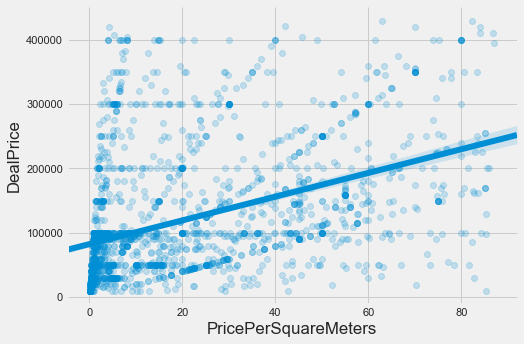

In [162]:
# Seaborn scatterplot with regression line
sns.lmplot(x='PricePerSquareMeters', y='DealPrice', data=df, aspect=1.5, scatter_kws={'alpha':0.2});
